# Sentinel-2-Bandstatistik ausgeben


Für ein Sentinel-2-Band möchte ich mir die Statistik des Bandes ausgeben, 
um mögliche Ausreißer zu finden und einen ersten Eindruck zu gewinnen, 
was die Daten angeht. Ich möchte mit rasterio sowie ergänzend mit notwendigen 
Bibliotheken wie numpy, matplotlib, ... arbeiten.

Die Teilschritte können in die gesamte Sentinel-2-Auswertungsroutine eingebaut und erweitert werden, auch in Schleifen für eine Anzahl von x Bändern.

In [13]:
import rasterio 
import matplotlib.pyplot as plt 
import numpy as np


## Band einladen und Metadaten ausgeben

In [82]:
band_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel-2_S1C\S2A_MSIL1C_20230225T153621_N0509_R068_T17NRA_20230225T190237.SAFE\GRANULE\L1C_T17NRA_A040105_20230225T153920\IMG_DATA\T17NRA_20230225T153621_B04.jp2"

band = rasterio.open(band_path)

# print(band.name) # Test ob das band richtig eingelesen wurde

In [83]:
band.count # anzahl der eingeladenen bänder

1

In [84]:
print(f"Die Breite des Bands ist {band.width} Pixel.")
print(f"Die Höhe des Bands ist {band.height} Pixel.")

Die Breite des Bands ist 10980 Pixel.
Die Höhe des Bands ist 10980 Pixel.


In [85]:
band.bounds # bounding box ausgeben


BoundingBox(left=799980.0, bottom=-9780.0, right=909780.0, top=100020.0)

In [86]:
band.crs # KBS ausgeben lassen

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]')

In [87]:
print(band.nodata)

None


In [88]:
band_values = band.read(1)
print(band_values)

[[8183 8085 8172 ... 6596 6440 6383]
 [8142 8052 8131 ... 6568 6361 6346]
 [8034 8015 8082 ... 6596 6429 6355]
 ...
 [2155 2122 2129 ... 2318 2382 2251]
 [2180 2130 2111 ... 2473 2430 2226]
 [2167 2132 2116 ... 2547 2326 2203]]


In [89]:
arr = np.array(band_values)

In [90]:
np.max(arr) # Rohdaten, alles > 10.000 sind im Regelfall sehr helle Pixel und Wolken. 15187 ist wsh. ein Störpixel.

22715

In [91]:
np.min(arr)

872

In [92]:
np.mean(arr)

2408.6615176956943

Rohdaten in physikalisch interpretierbare Reflexionen umrechnen: Durch 10.000 teilen. Dann sind alle Werte über 1 wsh. Übersteuerungen.

In [93]:
arr_umgerechnet = arr/10000

In [94]:
np.max(arr_umgerechnet)

2.2715

In [95]:
np.mean(arr_umgerechnet)

0.24086615176956952

In [96]:
np.min(arr_umgerechnet)

0.0872

In [98]:
arr_ohnenull = arr_umgerechnet[arr_umgerechnet > 0]
# Nullwerte des Sentinel-Bilds herausrechnen. Tritt in einigen Beispielen gar nicht auf, bei anderen auf einen angegebenen extent beschränkten bildern
# sind 85% null.

## Histogramm ausgeben

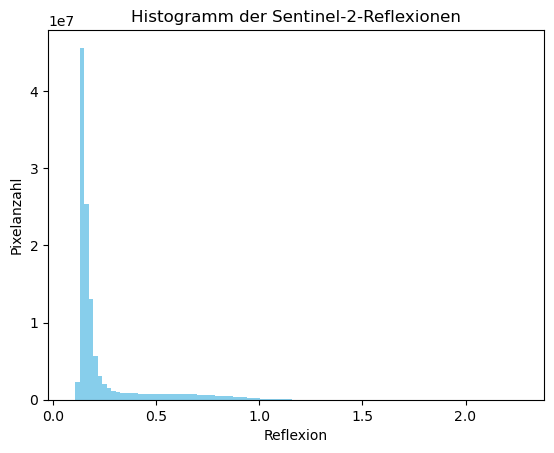

In [99]:
plt.hist(arr_ohnenull, bins=100, color='skyblue')
plt.xlabel('Reflexion')
plt.ylabel('Pixelanzahl')
plt.title('Histogramm der Sentinel-2-Reflexionen')
plt.show()

## Mögliche einfache Wolkenabschätzung

In [100]:
arr_cloud = arr_ohnenull > 1.0  
cloud_count = np.count_nonzero(arr_cloud)
print(f"{cloud_count} Pixel sind mutmaßlich wolkenbelastet. Das sind {np.count_nonzero(arr_cloud)/np.count_nonzero(arr_umgerechnet):.4f} % der Gesamtpixel.")

682666 Pixel sind mutmaßlich wolkenbelastet. Das sind 0.0057 % der Gesamtpixel.


## Nullwerte

In [101]:
mask_null = arr_umgerechnet == 0
count_null = np.count_nonzero(mask_null)
count_total = arr_umgerechnet.size
print(f"{count_null} Pixel sind gleich null."
      f"Das sind {count_null / count_total:.4%} der Gesamtpixel.")

0 Pixel sind gleich null.Das sind 0.0000% der Gesamtpixel.


In [102]:
count_total

120560400

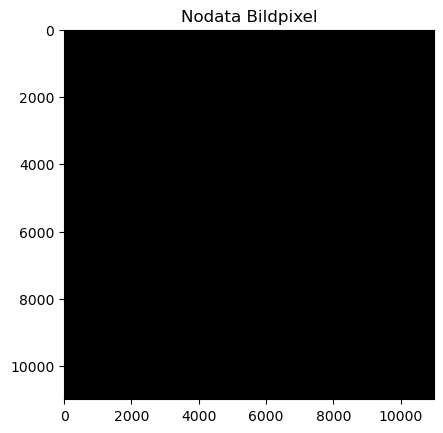

In [103]:
plt.imshow(arr_umgerechnet == 0, cmap='gray')
plt.title("Nodata Bildpixel")
plt.show()